# Data compression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

numpy version: 1.23.1
pandas version: 1.4.3


## The Wine data set

In [2]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
wine_df.shape

(178, 14)

In [3]:
wine_df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
wine_df.head(3)

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


## Data partition

In [4]:
from sklearn.model_selection import train_test_split

X, y = wine_df.iloc[:, 1:].values, wine_df.iloc[:, 0].values
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Data standardization

In [5]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Principal Component Analysis
The Principal Component Analysis is a technique used to reduce the space dimensionality a the data set. The information in the dataset is where the variance is higher so the basic idea is to find out the direction that contains the largest variance and then another direction, orthogonal to the first one, that contains what has been left from the first direction and so on till we have the amount of information that we want in a lower dimensional space. The steps to achieve this result are

1. Compute the covariance matrix $\Sigma$
2. Compute the eigen vectors and eigen values of the covariance matrix
3. Select the eigen vectors that contain most of the information (by their eigen values)
4. Build a projection matrix $W$ from the selected eigen vectors
5. Project the original data points onto the eigen vectors space so that $X'=XW$

### Covariance matrix
We use the covariance matrix to figure out whether there are features that are not completely independent. If there is any kind of relationships we might use only a subset of the original features instead of the full set of features without any loss of information. If the relationship cannot be decribed as an analytical function we still may use it to reduce the dimesional space but with some loss of information. The covariance matrix is defined as 

$$\sigma_{jk} = \sum_{i=1}^n (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)$$

where $\mu_J$ and $\mu_k$ are the sample mean of feature j and k respectively.

NumPy provides a function to compute the covariance matrix and we will use it to compute the covariance matrix of the Wine data set and its eigen values and eigen vectors.

In [6]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


The eigen values tell us which combination of feautures holds most of the variance. We can see that the first three eigen vectors contain 67% of the variance that is information.

In [7]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
sum(var_exp[:3])

0.6720155475408881

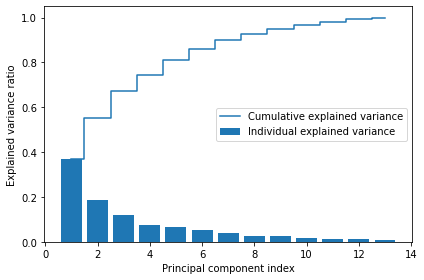

In [8]:
plt.bar(range(1, 14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The idea of PCA is to select the most important eigen vectors and map the input data set to the lower dimensional space defined by the selected high rank eigen vectors.  

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

We select two eigen vectors that define the space onto we want to project the input data. The two eigen vectors will define our projection matrix W from the original 13-dimensional space to the 2-dimensional eigen vectors space.

In [10]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
W.shape

(13, 2)

The projection of the data points from the original space 13-dimensional space onto the 2-dimensional eigen vectors space can be done via matrix multiplication. After the transformation each data point wil have two coordinates in the 2D eigen vectors space.

In [11]:
X_train_pca = X_train_std.dot(W)
X_train_pca.shape

(124, 2)

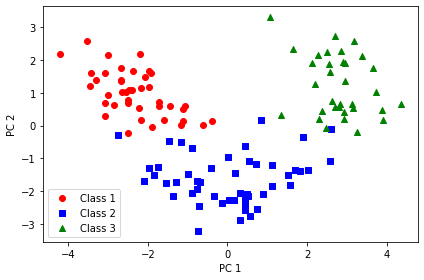

In [12]:
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

The contribution of the original features to each eigen vector are represented by the elements of the W matrix

$$x'_{ij} = \sum_{j=1}^n w_{ij}x_j$$

The coefficients $w_{ij}$ are called *loadings*. We can compute the contributions of the original features to each eigen vector x' as the ratio of the variance of the eigen vector and the sum of the variances of the original features. Since the mean value of the eigen vector.

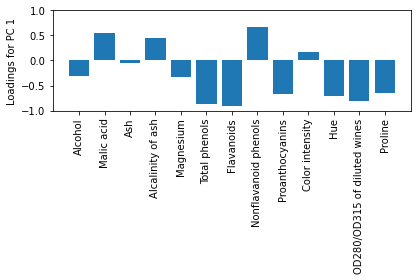

In [21]:
loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(wine_df.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## PCA with Scikit-Learn
Scikit-Learn provides several algorithm for principal components analysis. The [PCA](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca) module that we use returns the eigen vectors and eigen values and is based on the singular value decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)) algorithm.

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
sum(pca.explained_variance_ratio_)

1.0

We plot the data using only the first two eigen vectors

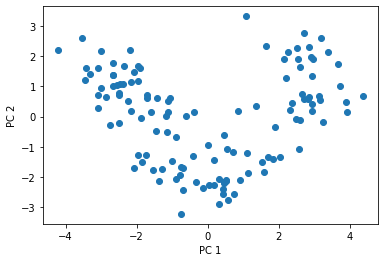

In [14]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Once we have the Wine data in a 2-dimensional space we can classify the data points using one of the algorithms we have seen, such as logistic regression.

In [15]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

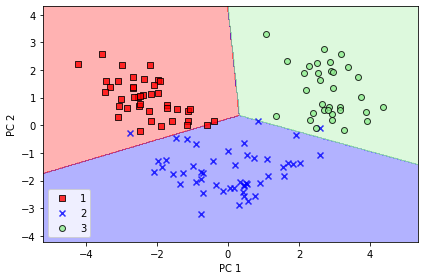

In [18]:
import plot_decision_regions_script
plot_decision_regions_script.plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Linear Discriminant Analysis